In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science','notebook'])

# Dinâmica Molecular no Ensemble NVE 

- $N$: número de partículas
- $V$: volume 
- $E$: energia


## Unidades reduzidas

Iremos usar unidades reduzidas

$$T^* = \frac{k_B T}{\epsilon}$$

$$\rho^* = \rho \sigma^2 $$

$$ t^* = \left( \frac{\epsilon}{m \sigma^2} \right)^{1/2} t$$

## Integrador Velocity-Verlet

Apropriado apenas para 2ª Lei de Newton. Utiliza um cálculo a mais de aceleração. 

$$x_{t+h} = x_t + v_t h + \frac{1}{2} a_t h^2$$

$$v_{t+h} = v_t + \frac{1}{2}(a_{t+h}+a_t) h $$

De modo que o algoritmo consiste em 

1. Calcula $x_{t+h}$ usando $v_t$ e $a_t$;
2. Calcula $a_{t+h}$ usando $x_{t+h}$;
3. Calcula $v_{t+h}$ para o próximo passo;
4. Volta ao passo 1;

Ref: https://pt.wikipedia.org/wiki/M%C3%A9todo_de_Verlet

Função que calcula o potencial de LJ entre pares

In [2]:
def ulj(r,epsilon=1.0,sigma=1.0):
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

Função que calcula a derivada do potencial de LJ entre pares

In [3]:
def duljdr(r,epsilon=1.0,sigma=1.0):
    return -48*epsilon*((sigma/r)**12-0.5*(sigma/r)**6)/r

In [4]:
class LJsystem():
    # Função que cria a classe
    def __init__(self,N_atoms, m = 1.0, epsilon = 1.0, sigma = 1.0, rcut = 2.5):
        self.N_atoms = N_atoms

        # parametros dos atomos
        self.m = m*np.ones(self.N_atoms)
        self.sigma = sigma*np.ones(self.N_atoms)
        self.epsilon = epsilon*np.ones(self.N_atoms)

        # parametro de cutoff da interação de LJ
        self.rcut = rcut

        # Arrays de posições
        self.x = np.zeros(self.N_atoms)
        self.y = np.zeros(self.N_atoms)
        self.z = np.zeros(self.N_atoms)

        # Arrays de velocidade
        self.vx = np.zeros(self.N_atoms)        
        self.vy = np.zeros(self.N_atoms) 
        self.vz = np.zeros(self.N_atoms) 

        # Arrays de aceleração
        self.ax = np.zeros(self.N_atoms)        
        self.ay = np.zeros(self.N_atoms)
        self.az = np.zeros(self.N_atoms)

    def Set_Density(self,rho):
        self.rho = rho
        # calcular o tamanho da caixa necessária 
        self.Lx = self.Ly = self.Lz = np.power(self.N_atoms/self.rho,1/3.0)

    def Initialize_Positions(self):
        # Número de pontos em x e y
        Nx = Ny = Nz = int(np.ceil(np.power(self.N_atoms,1/3.0)))

        # Espaçamento entre os átomos
        dx = self.Lx/Nx
        dy = self.Ly/Ny
        dz = self.Lz/Nz

        # Posições possíveis em x e y
        id = 0
        for i in range(Nx):
            for j in range(Ny):
                for k in range(Nz):
                    if (id < self.N_atoms):
                        self.x[id] = (i+0.5)*dx
                        self.y[id] = (j+0.5)*dy
                        self.z[id] = (k+0.5)*dz
                        id +=1
                        
    def Initialize_Velocities(self,kT= 1.0):
        self.kT = kT

        # sorteia uma distribuição normal com devio padrão proporcional a temperatura
        self.vx[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)
        self.vy[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)
        self.vz[:] = np.random.normal(loc=0.0, scale=np.sqrt(self.kT/self.m),size=self.N_atoms)

        # retira qualquer movimento total
        self.vx[:] -= self.vx.mean()
        self.vy[:] -= self.vy.mean()
        self.vz[:] -= self.vz.mean()

    def Get_KineticEnergy(self):
        self.K = np.sum(0.5*(self.vx**2+self.vy**2+self.vz**2))
        return self.K

    def Calculate_Interactions(self):
        self.ax[:] = 0.0
        self.ay[:] = 0.0
        self.az[:] = 0.0
        self.U = 0.0
        for i in range(self.N_atoms):
            for j in range(i+1,self.N_atoms):
                # calcula distancia entre duas particulas
                rx = self.x[i] - self.x[j]
                ry = self.y[i] - self.y[j]
                rz = self.z[i] - self.z[j]
                # testa condição de contorno periodica para imagens
                rx -= np.rint(rx/self.Lx)*self.Lx # em x
                ry -= np.rint(ry/self.Ly)*self.Ly # em y
                rz -= np.rint(rz/self.Lz)*self.Lz # em y
                # calcula modulo da distancia 
                r = np.sqrt(rx**2 + ry**2 + rz**2)
                # regra de combinação de Lorenz-Berthelot
                epsilonij = np.sqrt(self.epsilon[i]*self.epsilon[j])
                sigmaij = 0.5*(self.sigma[i]+self.sigma[j])
                # Vamos considerar somente interação dentro do raio de corte
                if r < self.rcut*sigmaij:
                    # calcula a derivada do potencial 
                    dudr = duljdr(r,epsilonij,sigmaij)
                    # calcula aceleração na particula i 
                    self.ax[i] += -dudr*rx/r
                    self.ay[i] += -dudr*ry/r
                    self.az[i] += -dudr*rz/r
                    # calcula aceleração na particula j usando 3ª Lei de Newton 
                    self.ax[j] += dudr*rx/r
                    self.ay[j] += dudr*ry/r
                    self.az[j] += dudr*rz/r
                    # calcula energia interna
                    self.U += ulj(r,epsilonij,sigmaij)

    def Get_PotentialEnergy(self):
        return self.U
    
    def Get_Energies(self):
        self.Get_KineticEnergy()
        kT = 2*self.K/(3*self.N_atoms)
        return self.K, self.U, kT
    
    def Set_TimeStep(self,h):
        self.h = h
    
    def Calculate_TimeStep(self):
        # update das velocidades
        self.vx[:] += 0.5*self.ax*self.h
        self.vy[:] += 0.5*self.ay*self.h
        self.vz[:] += 0.5*self.az*self.h
        # update das posições
        self.x[:] += self.h * self.vx
        self.y[:] += self.h * self.vy
        self.z[:] += self.h * self.vz
        # condição de contorno periódica se pártícula saiu da caixa
        self.x[:] = self.x % self.Lx # em x
        self.y[:] = self.y % self.Ly # em y
        self.z[:] = self.z % self.Lz # em z
        # calcula nova aceleração 
        self.Calculate_Interactions()
        # update das velocidades
        self.vx[:] += 0.5*self.ax*self.h
        self.vy[:] += 0.5*self.ay*self.h
        self.vz[:] += 0.5*self.az*self.h

    def RunSimulation(self,N_steps,Step_to_print=10):
        self.N_steps = N_steps
        self.Step_to_print = Step_to_print # steps to print output

        self.Calculate_Interactions()

        print('iter\t K\t U\t E\t T')
        Ktemp, Utemp, Ttemp = self.Get_Energies()
        print(f'{0:5d}\t {Ktemp:.4f}\t {Utemp:.4f}\t {Ktemp+Utemp:.4f}\t {Ttemp:.4f}')

        t = [0]
        K = [Ktemp]
        U = [Utemp]
        E = [Ktemp+Utemp]
        T = [Ttemp]

        for i in range(1,self.N_steps+1):

            self.Calculate_TimeStep()

            if i % self.Step_to_print == 0:
                Ktemp, Utemp, Ttemp = self.Get_Energies()
                t.append(i)
                K.append(Ktemp)
                U.append(Utemp)
                E.append(Ktemp+Utemp)
                T.append(Ttemp)
                print(f'{i:5d}\t {Ktemp:.4f}\t {Utemp:.4f}\t {Ktemp+Utemp:.4f}\t {Ttemp:.4f}')

        return np.array(t), np.array(K), np.array(U), np.array(E), np.array(T)

In [5]:
lj2d = LJsystem(N_atoms=216,m=1.0,epsilon=1.0,sigma=1.0)
lj2d.Set_Density(0.55)
lj2d.Initialize_Positions()
lj2d.Initialize_Velocities(kT=1.38)
lj2d.Calculate_Interactions()
lj2d.Get_Energies()

(454.67652297454845, -785.9833300437623, 1.4033226017732976)

Text(0, 0.5, 'y')

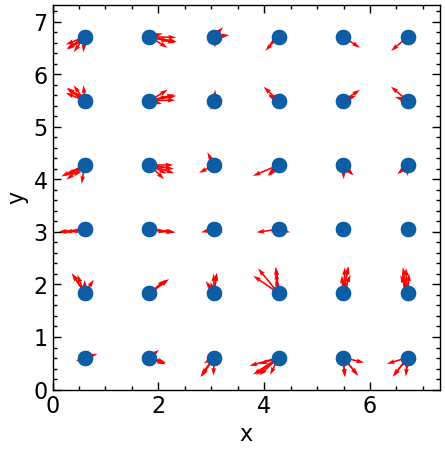

In [6]:
plt.figure(figsize=(5,5))
plt.plot(lj2d.x,lj2d.z,'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(lj2d.x,lj2d.z,lj2d.ax,lj2d.az,color='r') # vetor de velocidade

plt.xlim(0,lj2d.Lx)
plt.ylim(0,lj2d.Ly)

plt.xlabel('x')
plt.ylabel('y')

In [7]:
lj2d.Set_TimeStep(h=0.005)

t, K, U, E, T = lj2d.RunSimulation(N_steps=500,Step_to_print=10)

iter	 K	 U	 E	 T
    0	 454.6765	 -785.9833	 -331.3068	 1.4033
   10	 432.8508	 -761.7387	 -328.8879	 1.3360
   20	 354.0793	 -684.2165	 -330.1372	 1.0928
   30	 360.4837	 -693.0468	 -332.5631	 1.1126
   40	 379.0088	 -713.3223	 -334.3135	 1.1698
   50	 399.9528	 -735.3536	 -335.4009	 1.2344
   60	 380.0429	 -715.8208	 -335.7779	 1.1730
   70	 387.9211	 -724.1894	 -336.2683	 1.1973
   80	 409.9348	 -746.6292	 -336.6944	 1.2652
   90	 378.3808	 -715.5678	 -337.1869	 1.1678
  100	 392.8250	 -730.4400	 -337.6149	 1.2124
  110	 408.6334	 -746.2932	 -337.6597	 1.2612
  120	 415.7364	 -753.3600	 -337.6236	 1.2831
  130	 394.0718	 -731.6580	 -337.5863	 1.2163
  140	 411.3207	 -749.3667	 -338.0460	 1.2695
  150	 379.5434	 -717.4095	 -337.8660	 1.1714
  160	 403.8631	 -741.9449	 -338.0819	 1.2465
  170	 401.2994	 -739.2361	 -337.9367	 1.2386
  180	 411.4058	 -749.6158	 -338.2099	 1.2698
  190	 416.8284	 -755.1727	 -338.3443	 1.2865
  200	 407.1452	 -745.3378	 -338.1926	 1.2566
  210	 411.5012	 

Gráfico das posições finais das partículas

Text(0, 0.5, 'y')

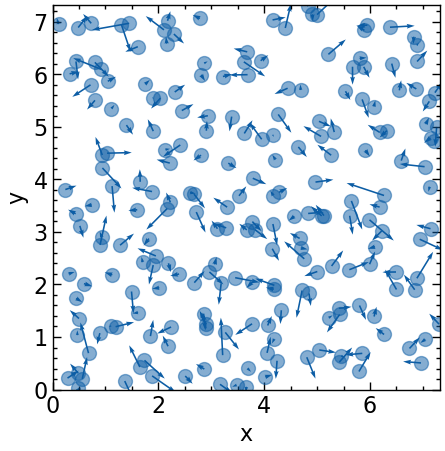

In [8]:
plt.figure(figsize=(5,5))
plt.plot(lj2d.x,lj2d.y,'o',ms=10.0,alpha=0.5) # posição das partículas
plt.quiver(lj2d.x,lj2d.y,lj2d.vx,lj2d.vy,color='C0') # vetor de velocidade

plt.xlim(0,lj2d.Lx)
plt.ylim(0,lj2d.Ly)

plt.xlabel('x')
plt.ylabel('y')

Gráfico da evolução de $U$ e $T$ como função dos passos de iteração

Text(0, 0.5, '$k_B T/\\epsilon$')

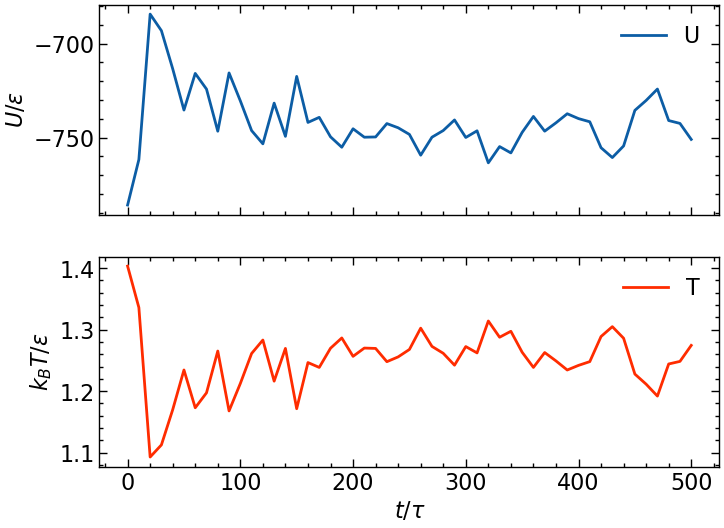

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].plot(t,U,label='U')
axs[0].legend(loc='best')
axs[0].set_ylabel(r'$U/\epsilon$')

axs[1].plot(t,T,color='C3',label='T')
axs[1].legend(loc='best')
axs[1].set_xlabel(r'$t/\tau$')
axs[1].set_ylabel(r'$k_B T/\epsilon$')

## Calculando Médias e Desvios Padrão

In [17]:
teq = 150
subsett = t[t>teq]
subsetT = T[t>teq]
subsetU = U[t>teq]

In [18]:
Umean = subsetU.mean()

print(Umean)

-746.4013333791852


In [19]:
sigmaU = subsetU.std()

print(sigmaU)

8.365680952903748


$$U/\epsilon = -746 \pm 8 $$

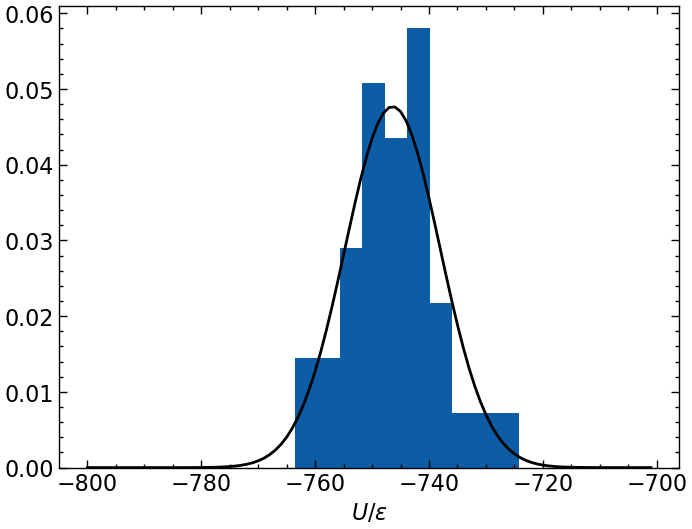

In [20]:
plt.hist(subsetU,density=True)
plt.xlabel(r'$U/\epsilon$')

uarray = np.arange(-800,-700,1)
plt.plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

In [21]:
Tmean = subsetT.mean()

print(Tmean)

1.2610795355862767


In [22]:
sigmaT = subsetT.std()

print(sigmaT)

0.025766893420133125


$$ k_B T /\epsilon = 1.26 \pm 0.03$$

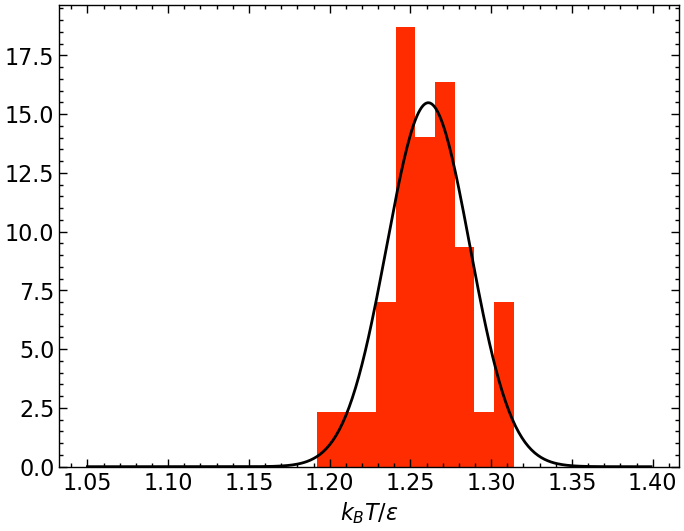

In [23]:
plt.hist(subsetT,density=True,color='C3')
plt.xlabel(r'$k_B T/\epsilon$')

Tarray = np.arange(1.05,1.4,0.001)
plt.plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')